In [1]:
import os

import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import numpy.linalg as la
from scipy.sparse import csc_matrix, csr_matrix
from tqdm.auto import tqdm

from datasets import get_dataset
from first_order import Ig, Nesterov
from loss_functions import LogisticRegression
from stochastic_first_order import Sgd, Shuffling, ClippedShuffling
from utils import get_trace, relative_round
%load_ext autoreload
%autoreload 2

import matplotlib
sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

In [2]:
dataset = 'w8a'
A, b = get_dataset(dataset)

loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness()
l2 = L / np.sqrt(n)
loss.l2 = l2
x0 = csc_matrix((dim, 1))
n_epoch = 600
batch_size = 512
# n_seeds = 2 # was set to 20 in the paper
n_seeds = 10
stoch_it = 250 * n // batch_size
trace_len = 300
trace_path = f'results/log_reg_{dataset}_l2_{relative_round(l2)}/'

In [4]:
L_b = 1 / loss.batch_smoothness(batch_size)

In [7]:
L, L_b

(0.6611993844944792, 1.3928004099528104)

## Load experimental results

Baselines

In [3]:
print('Finding optimal point')
nest_str_trace = get_trace(f'{trace_path}nest_str', loss)
assert nest_str_trace is not None, 'Optimal point was not found yet!'
f_opt = np.min(nest_str_trace.loss_vals)
x_opt = nest_str_trace.xs[-1]

print('Random Reshuffling')
rr_trace = get_trace(f'{trace_path}rr', loss)
assert rr_trace is not None, 'Random Reshuffling trace is None!'

print('Single Random Reshuffling')
so_trace = get_trace(f'{trace_path}so', loss)
assert so_trace is not None, 'Single Random Reshuffling trace is None!'

print('Regular SGD')
sgd_trace = get_trace(f'{trace_path}sgd_no_miss', loss)
assert sgd_trace is not None, 'SGD trace with single permutation is None'

print('Deterministic Reshuffling')
ig_trace = get_trace(f'{trace_path}ig', loss)

Finding optimal point
Random Reshuffling
Single Random Reshuffling
Regular SGD
Deterministic Reshuffling


Different reshufflings with clipping

In [6]:
print('Clipped Random Reshuffling')
c_rr_traces = []
clip_level_list = np.logspace(-3, 2, 6)
for clip_level in tqdm(clip_level_list):
    c_rr_trace = get_trace(f'{trace_path}c_{clip_level}_rr', loss)
    assert c_rr_trace is not None, f'Clipped Random Reshuffling trace is None for clip_level={clip_level}!'
    c_rr_traces.append(c_rr_trace)

print('Clipped Random Reshuffling Opt')
c_rr_opt_traces = []
for clip_level in tqdm(clip_level_list):
    c_rr_opt_trace = get_trace(f'{trace_path}c_{clip_level}_opt_rr', loss)
    assert c_rr_opt_trace is not None, f'Clipped Random Reshuffling Opt trace is None for clip_level={clip_level}!'
    c_rr_opt_traces.append(c_rr_opt_trace)

print('Clipping with shifts')
alpha_shifts = [100, 10, 1, 0.1]
c_rr_shift_traces_dict = {}
for alpha_shift in alpha_shifts:
    c_rr_shift_traces = []
    c_rr_shift_traces_dict[alpha_shift] = c_rr_shift_traces
    for clip_level in tqdm(clip_level_list):
        trace_file_name = f'c_{clip_level}_a_shift_{alpha_shift}_rr'
        trace_file_path = f'{trace_path}{trace_file_name}'
        c_rr_shift_trace = get_trace(trace_file_path, loss)
        assert c_rr_shift_trace is not None, \
            f'Clipped Random Reshuffling Shift trace is None for alpha={alpha_shift}, clip_level={clip_level}!'
        c_rr_shift_traces.append(c_rr_shift_trace)

Clipped Random Reshuffling


  0%|          | 0/6 [00:00<?, ?it/s]

Clipped Random Reshuffling Opt


  0%|          | 0/6 [00:00<?, ?it/s]

Clipping with shifts


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Performance plots

In [7]:
ncols = 2 if len(clip_level_list) >= 2 else 1
nrows = int(np.ceil(len(clip_level_list) / 2))

## Everything, everywhere at once

### Functional residual

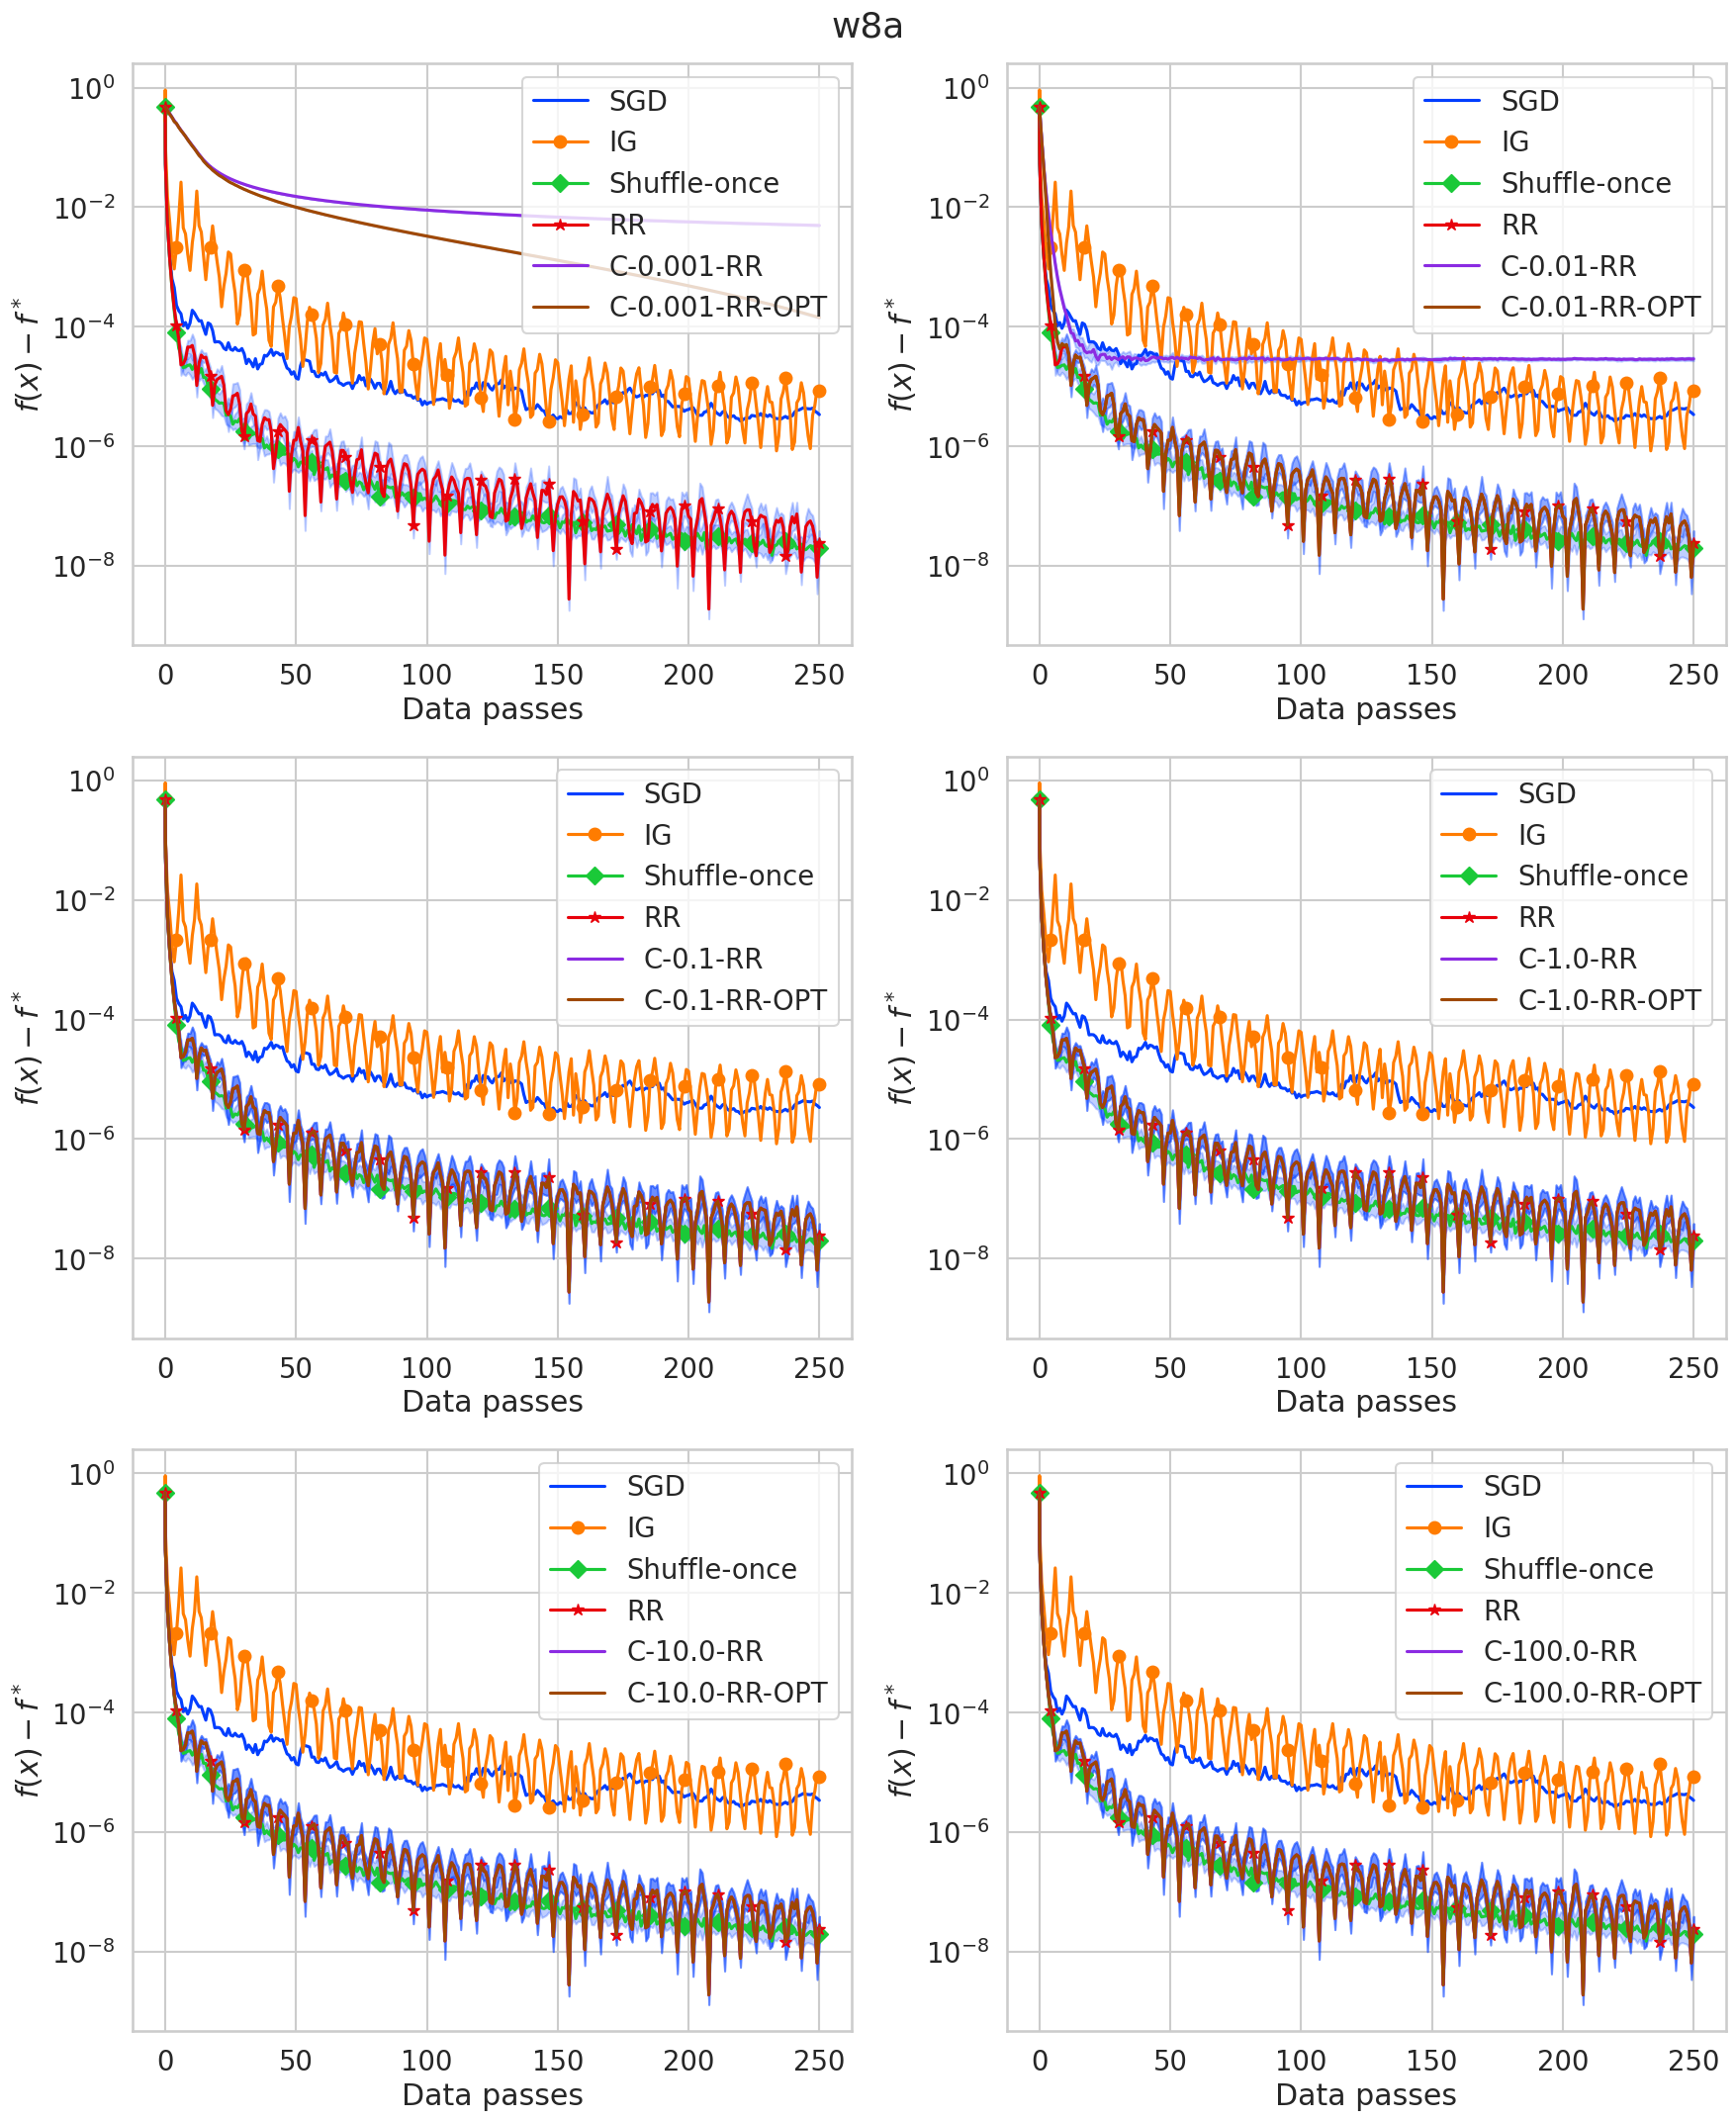

In [10]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 22))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_func.png', dpi=300)

### Distance to solution

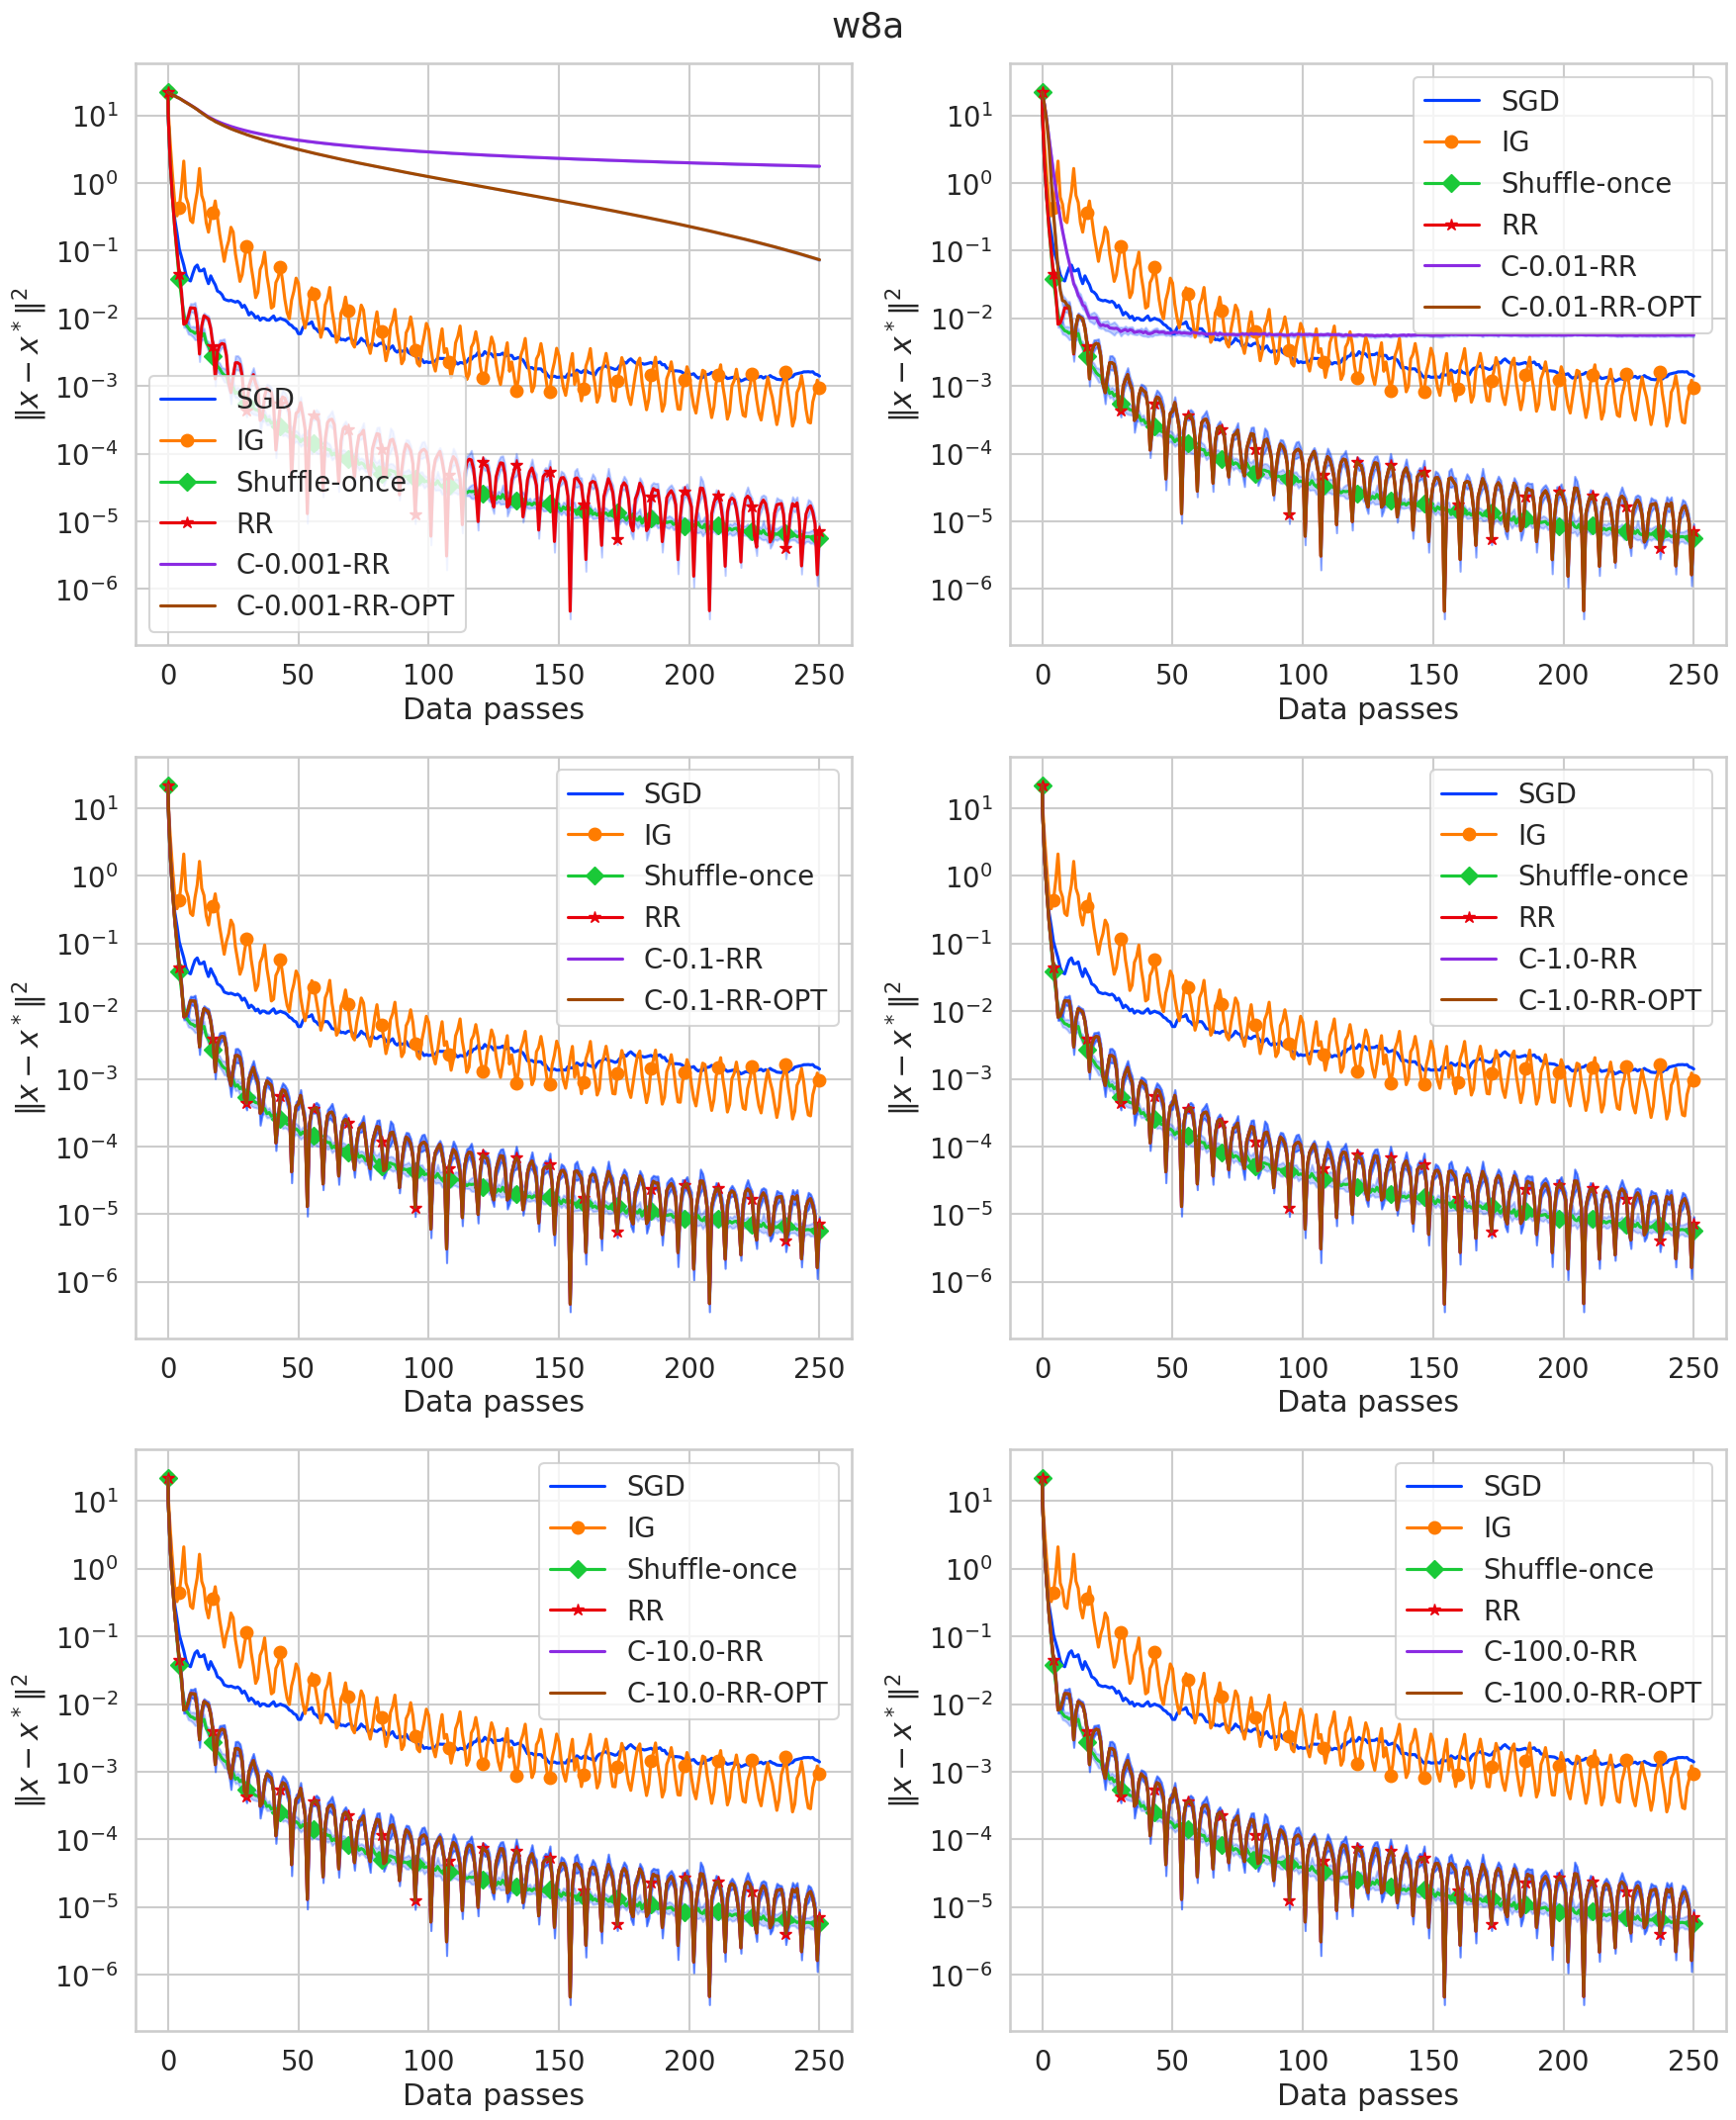

In [ ]:
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(18, 22))
for ax, c_rr_trace, c_rr_opt_trace, clip_level in zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list):
    traces = [sgd_trace, ig_trace, so_trace, rr_trace, c_rr_trace, c_rr_opt_trace]
    labels = ['SGD', 'IG', 'Shuffle-once', 'RR', f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', 'o', 'D', '*', ',', ',']
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_dist.png', dpi=300)

## Only CRR

### Functional residual

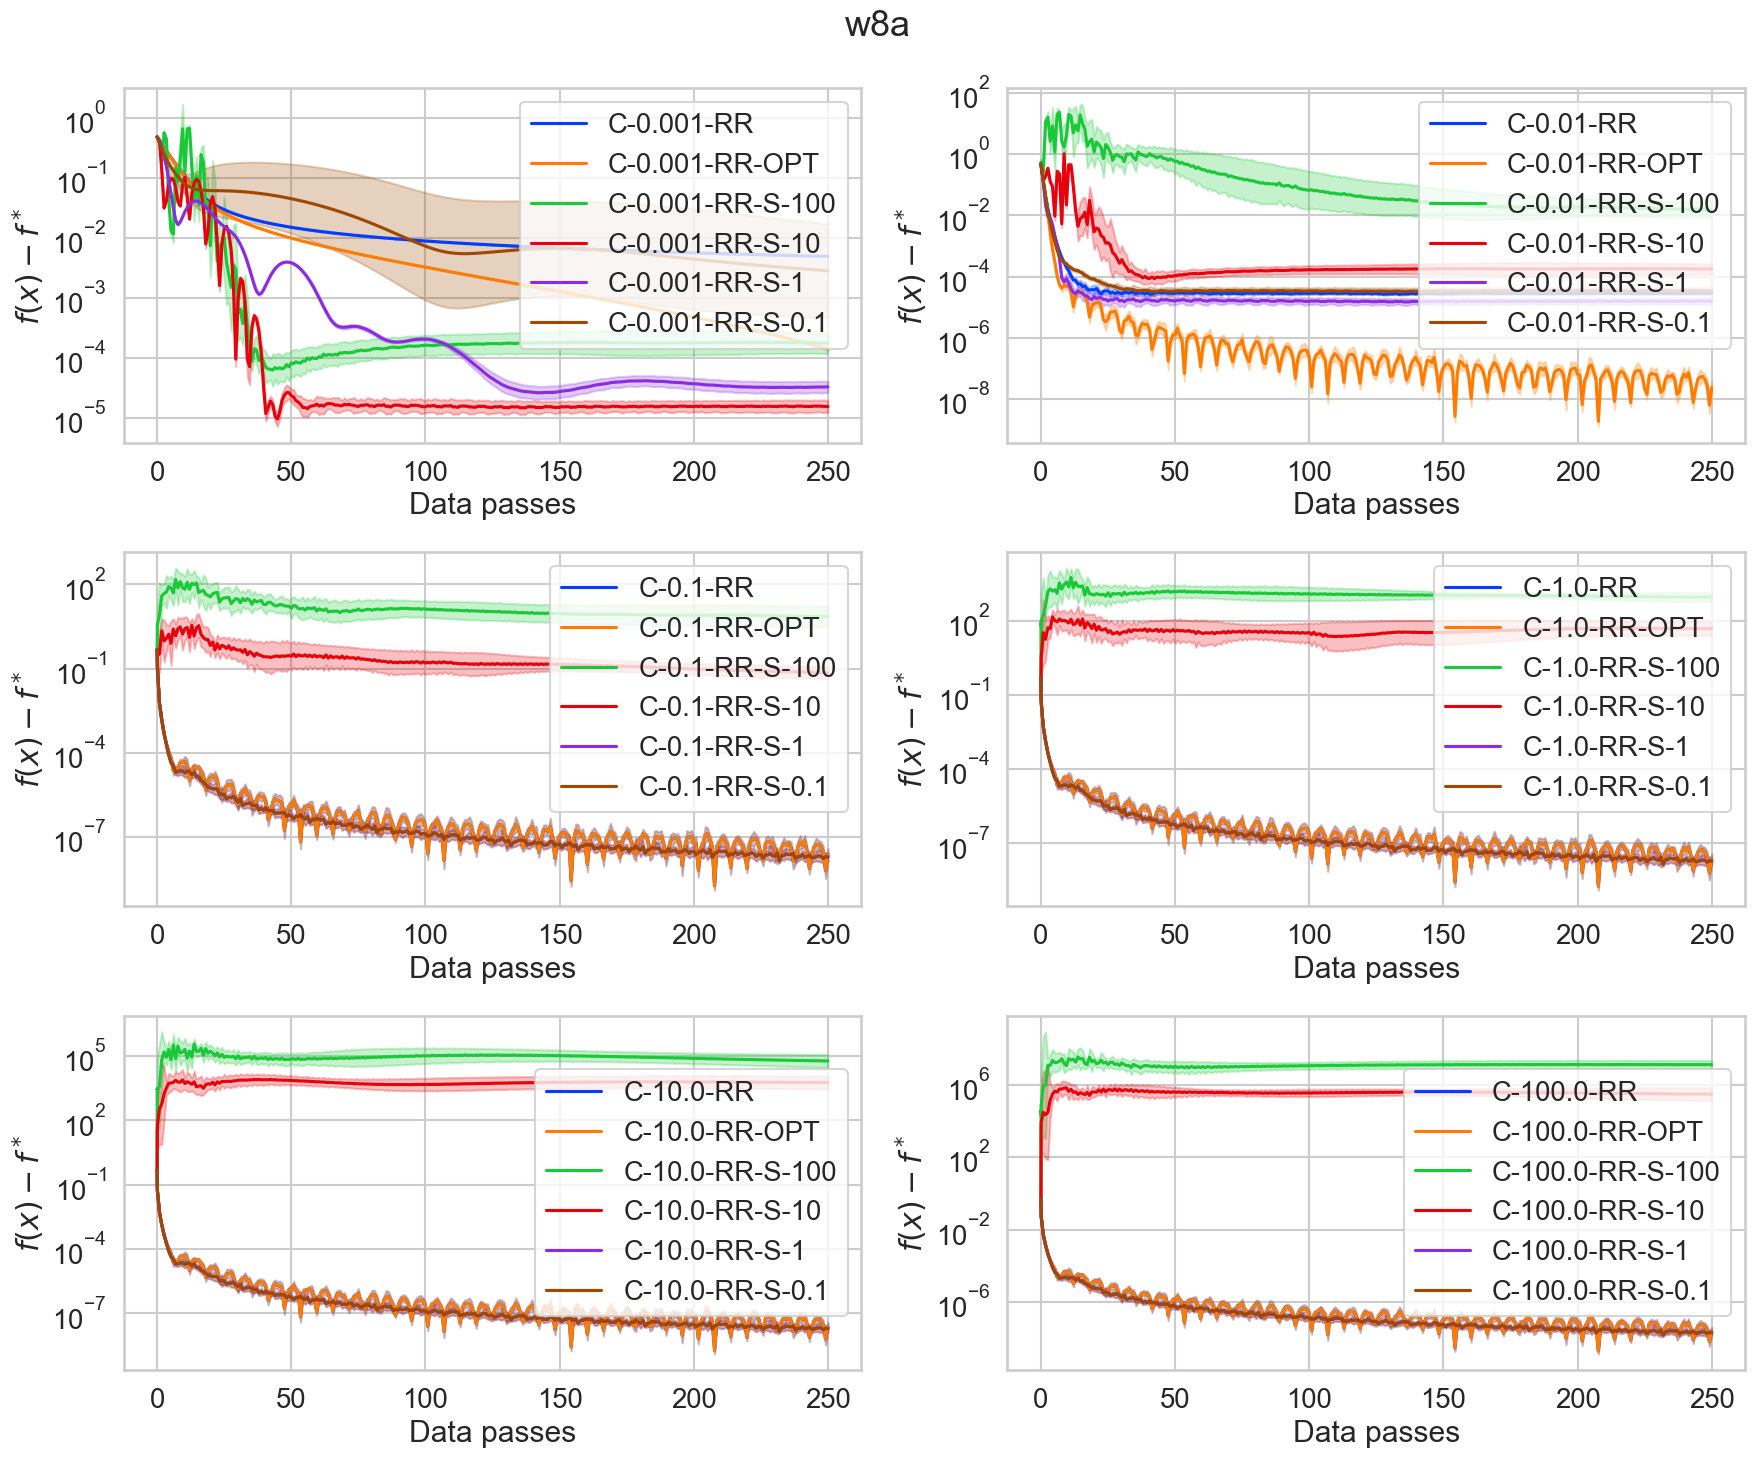

In [8]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 15))
for (i, (ax, c_rr_trace, c_rr_opt_trace, clip_level)) in \
    enumerate(zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list)):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for a, c_rr_shift_traces in c_rr_shift_traces_dict.items():
        traces.append(c_rr_shift_traces[i])
        labels.append(f'C-{clip_level}-RR-S-{a}')
        markers.append(',')
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_losses(f_opt=f_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_func_rr_opt_shift.png', dpi=300)

### Distance to solution

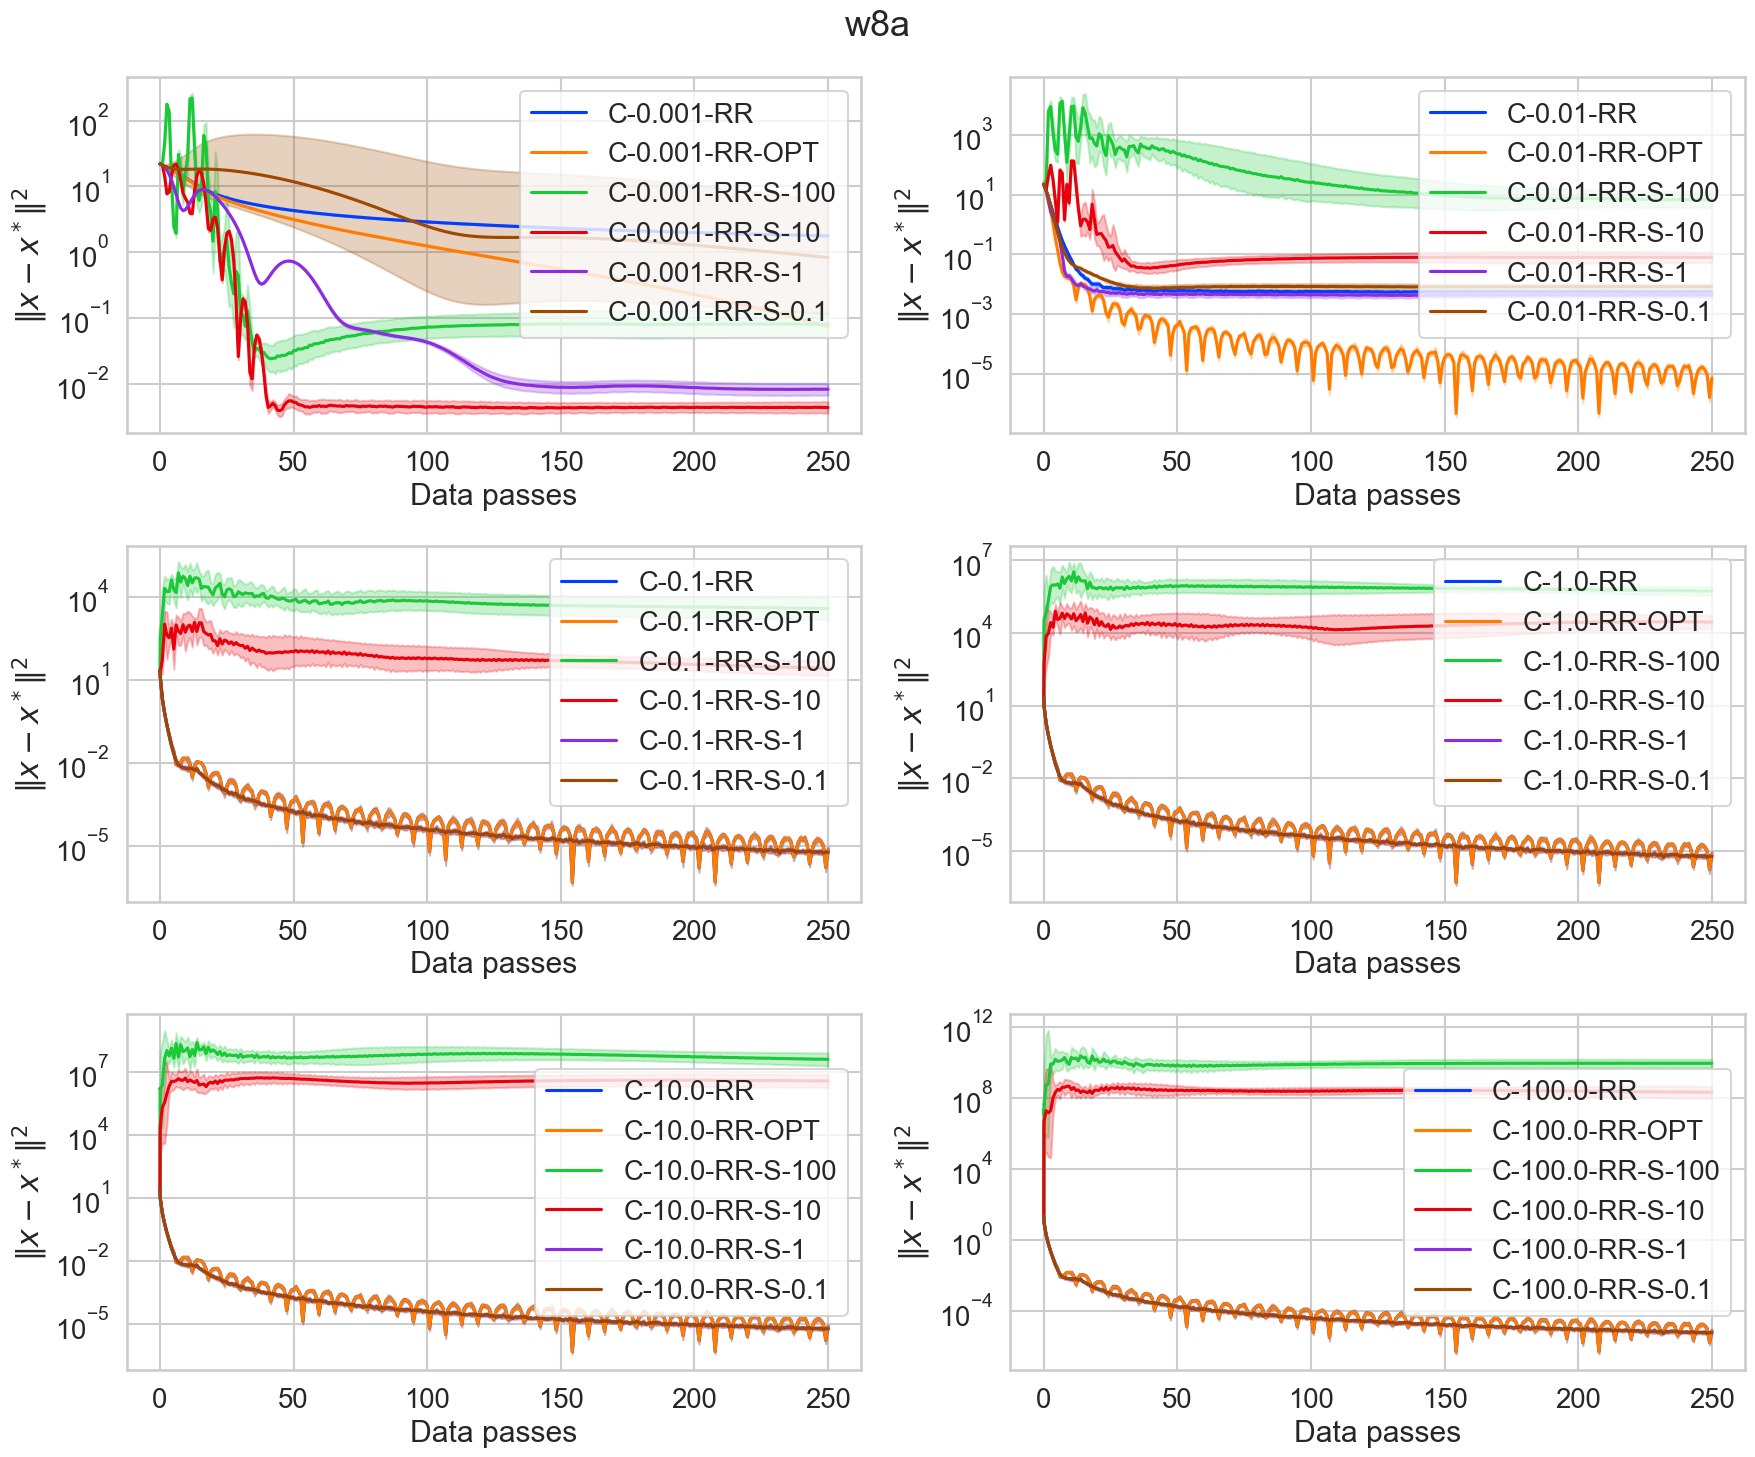

In [9]:
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 15))
for (i, (ax, c_rr_trace, c_rr_opt_trace, clip_level)) in \
    enumerate(zip(axis.flatten(), c_rr_traces, c_rr_opt_traces, clip_level_list)):
    traces = [c_rr_trace, c_rr_opt_trace]
    labels = [f'C-{clip_level}-RR', f'C-{clip_level}-RR-OPT']
    markers = [',', ',']
    for a, c_rr_shift_traces in c_rr_shift_traces_dict.items():
        traces.append(c_rr_shift_traces[i])
        labels.append(f'C-{clip_level}-RR-S-{a}')
        markers.append(',')
    for trace, label, marker in zip(traces, labels, markers):
        trace.plot_distances(x_opt=x_opt, label=label, ax=ax, marker=marker)
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('Data passes')
fig.suptitle(dataset)
fig.tight_layout()
plt.savefig(f'./plots/{dataset}_dist_rr_opt_shift.png', dpi=300)